In [32]:
import os
from dotenv import load_dotenv
load_dotenv()
load_dotenv(override=True)

True

In [33]:
REDIS_URL = os.getenv("REDIS_URL")
REDIS_HOST = os.getenv("REDIS_HOST")
REDIS_PORT = int(os.getenv("REDIS_PORT"))  # Cast to int
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD")

In [34]:
# connect to Redis
import redis

r=redis.Redis(
    host=REDIS_HOST,
    port=REDIS_PORT,
    password=REDIS_PASSWORD,
    decode_responses=True
)

In [35]:
# check the redis connection
print(r.ping())  # Should return True if connected successfully

True


In [36]:
r.flushdb()  # Clear the database

True

In [37]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en")


In [38]:
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage

In [39]:
llm_groq = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model="qwen/qwen3-32b",
    temperature=0.7,
    max_tokens=1000
)


In [40]:
from datasets import load_dataset

# Load the dataset from Hugging Face hub
data = load_dataset("ashraq/fashion-product-images-small", split="train")

# Shuffle the dataset
data = data.shuffle(seed=42)

# Optional: Inspect
print(data)


Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})


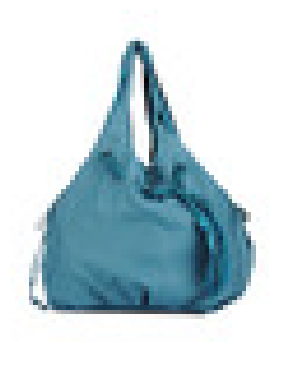

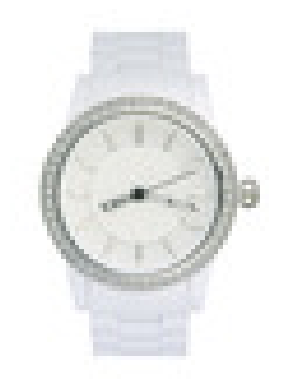

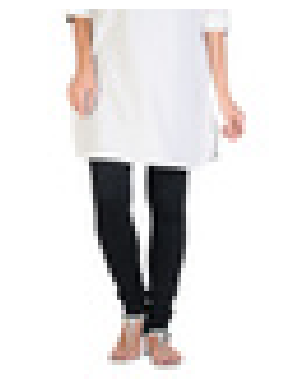

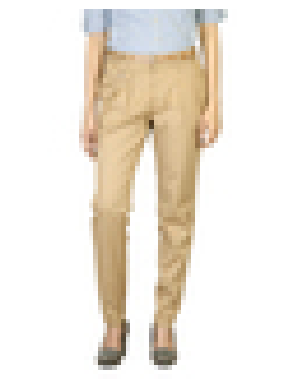

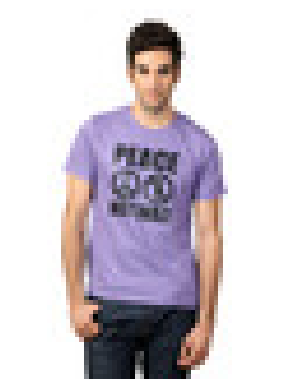

In [41]:
import matplotlib.pyplot as plt

for i in range(5):
    sample = data[i]
    image = sample["image"]
    
    plt.imshow(image)
    plt.axis("off")
    
    # If the dataset has labels, you can display them
    if "label" in sample:
        plt.title(f"Label: {sample['label']}")
    
    plt.show()

In [42]:
images = data["image"]
data = data.remove_columns("image")
products =data.to_pandas()

texts = products.head(500)["productDisplayName"].to_list()

In [43]:
texts

['Baggit Women Blue Bag',
 'DKNY Women White Dial Watch NY8011',
 'Fabindia Women Black Churidar',
 'Scullers For Her Women Tan Trousers',
 'Myntra Men Purple T-shirt',
 'Nike Women Cruiser Hurley Dot Pink T-shirt',
 'Basics Men Green Checked Shirt',
 'Regent Polo Men Check Black Shirt',
 'Gini and Jony Boys Core Black T-shirt',
 'Carlton London Women Casual Black Wedges',
 'Salomon Men Exit 2 Aero Brown Sports Shoes',
 'Murcia Women Black Leatherite Handbag',
 'Lomani Men Allure Sport Deo',
 'Red Tape Men Brown Sandals',
 'Enamor Women Classique White Bra',
 'Nike Men Pack of 3 Socks',
 'Mark Taylor Men Printed White T-shirt',
 'Hanes Men Black Shorts',
 "Fila Men's Basic Low Red Shoe",
 'Hanes Men Sleeveless Crew White Innerwear T-shirt',
 'Umbro Men Set of 2 Deos',
 'Arrow Woman Hallie Olive Shirt',
 'Manchester United Men Printed White Tshirt',
 'Estee Lauder Women Pleasures Bloom 100 ml Perfume',
 'Force 10 Men Beige Sports Shoes',
 "Myntra Men's Creative Designs Navy Blue T-shirt

## Simple RAG

In [44]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import Redis
from langchain_core.documents import Document

In [45]:
rds = Redis.from_texts(
    texts=texts,
    embedding=embeddings,
    redis_url=REDIS_URL,
    index_name="products"
)

In [46]:
rds.index_name

'products'

In [47]:
retriever = rds.as_retriever(search_type="similarity", search_kwargs={"k": 10})

In [48]:
retriever.invoke("Jeans")

[Document(metadata={'id': 'doc:products:9944eef2a307415bbc881f4e4c6fda7e'}, page_content='Peter England Men Party Black Jeans'),
 Document(metadata={'id': 'doc:products:2f78726d3fc14b6b940cf7f6d263d40b'}, page_content='United Colors of Benetton Men Washed Blue Jeans'),
 Document(metadata={'id': 'doc:products:24fac8dbb65f40d287a65b926fd4e917'}, page_content='Lee Men Light Blue Chicago Fit Jeans'),
 Document(metadata={'id': 'doc:products:42410667489f44eeae86833becdddf33'}, page_content='Lee Men Blue Party Jeans'),
 Document(metadata={'id': 'doc:products:c370c6b144c648aa954f18b7d040d450'}, page_content='Kraus Jeans Women Blue Leggings'),
 Document(metadata={'id': 'doc:products:70ec37bd16e847659081857d68957b23'}, page_content='Kraus Jeans Women Blue Capris'),
 Document(metadata={'id': 'doc:products:deab2692b0904b12a18d40f82118f1e6'}, page_content='Gini and Jony Boys Comics Blue Jeans'),
 Document(metadata={'id': 'doc:products:395bb9b8206e4c61993855c4cfdd7283'}, page_content='Spykar Men Ski

In [49]:
template = """Anser the question based on the context below: {context}.
 If you don't know the answer, just say that you don't know, don't try to make up an answer.
 Question: {question}"""

prompt = ChatPromptTemplate.from_template(
    template
)

In [50]:
chain = (
    {    "context": (lambda x: x["question"]) | retriever,
        "question": (lambda x: x["question"])  } |
    prompt |
    llm_groq |
    StrOutputParser()
)

In [51]:
answer = chain.invoke({
    "question": "What is the best product for summer?" })

In [52]:
print(answer)

<think>
Okay, let's see. The user is asking for the best product for summer. I need to look at the list of products provided and figure out which one would be suitable for summer.

First, I'll go through each product one by one. 

1. Avirate Cream Nightdress: Nightwear, maybe lightweight? Not sure, but nightdress might not be the first choice for summer activities.
2. Reebok Reelive Women Perfumes: Perfumes are seasonal, but summer perfumes might be lighter. However, the description doesn't specify it's for summer.
3. Biotique Women Bio Almond Eye Cream: Eye cream is a skincare product. Not directly related to seasons unless it's for sun protection, but no info here.
4. Azzaro Men Chrome Eau de Toilette 200 ml: Men's perfume. Similar to the Reebok one; not sure if it's summer-specific.
5. ADIDAS White Water Sipper: A water bottle. Summer is hot, so staying hydrated is important. This could be a practical summer product.
6. Scullers For Her Beige Trouser: Beige trousers might be light-c

In [53]:
answer1 = chain.invoke({
    "question": "I am looking for a nice pair of jean" })
print(answer1)

<think>
Okay, the user is looking for a nice pair of jeans. Let me check the documents provided.

First document is Lee Men Light Blue Chicago Fit Jeans. That's a jean. Second is Lee Men Blue Party Jeans. Another jean. Third is Kraus Jeans Women Blue Leggings – wait, leggings might not be jeans. Then there's United Colors of Benetton Men Washed Blue Jeans. That's definitely jeans. French Connection Women Navy Trouser – trousers, not jeans. Kraus Jeans Women Blue Capris – capris are a type of pants but not sure if they're jeans. The rest are sandals, caps, pyjamas, and a kurta. 

So the main jeans options are the Lee ones, Benetton, and maybe the Kraus Jeans capris. The user didn't specify gender, but the options have men and women. If they want men's, Lee and Benetton are good. If women's, Kraus. Should I list all the jeans options? Also, need to check if the user wants a specific fit or style. Since they just said "nice pair," maybe recommend the top ones. Let me make sure I didn't mi

## Hybrid Rag

In [54]:
r.flushdb()  # Clear the database

True

In [55]:
metadatas = products.head(500).to_dict(orient="records")
metadatas[0]

{'id': 47396,
 'gender': 'Women',
 'masterCategory': 'Accessories',
 'subCategory': 'Bags',
 'articleType': 'Handbags',
 'baseColour': 'Blue',
 'season': 'Summer',
 'year': 2012.0,
 'usage': 'Casual',
 'productDisplayName': 'Baggit Women Blue Bag'}

In [56]:
rds = Redis.from_texts(
    texts=texts,
    embedding=embeddings,
    redis_url=REDIS_URL,
    index_name="products",
    metadatas=metadatas
)

In [58]:
from langchain_community.vectorstores.redis import RedisFilter 

In [59]:
season = RedisFilter.text("season")== "summer"

In [60]:
retriever = rds.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4, "filter":season},
    )

In [61]:
retriever.invoke("jeans")

[Document(metadata={'id': 'doc:products:12e4b6d1d3bf419b9da9878ece0406ac', 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Bottomwear', 'articleType': 'Jeans', 'baseColour': 'Black', 'season': 'Summer', 'usage': 'Casual', 'productDisplayName': 'Peter England Men Party Black Jeans', 'year': '2012'}, page_content='Peter England Men Party Black Jeans'),
 Document(metadata={'id': 'doc:products:c50ffd1ff8b145b4aa85bcee6b340284', 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Bottomwear', 'articleType': 'Jeans', 'baseColour': 'Blue', 'season': 'Summer', 'usage': 'Casual', 'productDisplayName': 'Lee Men Light Blue Chicago Fit Jeans', 'year': '2017'}, page_content='Lee Men Light Blue Chicago Fit Jeans'),
 Document(metadata={'id': 'doc:products:6c3e1fe814604ff0b6b3eb3c87b56fda', 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Bottomwear', 'articleType': 'Jeans', 'baseColour': 'Blue', 'season': 'Summer', 'usage': 'Casual', 'productDisplayName': 'Lee Men

In [62]:
template = """Anser the question based on the context below: {context}.
 If you don't know the answer, just say that you don't know, don't try to make up an answer.
 Question: {question}"""

prompt = ChatPromptTemplate.from_template(
    template
)

chain = (
    {    "context": (lambda x: x["question"]) | retriever,
        "question": (lambda x: x["question"])  } |
    prompt |
    llm_groq |
    StrOutputParser()
)

In [63]:
answer2 = chain.invoke({
    "question": "I am looking for some nice pants. Please suggest some and give some info on the season" })
print(answer2)

<think>
Okay, let me see. The user is asking for some nice pants and wants suggestions along with info on the season. I need to check the provided documents to find relevant products.

Looking at the documents, there are four entries. The first one is a Women's Kurta, which is a top, not pants. The second document is "Fabindia Men White Pyjamas" under the subCategory "Loungewear and Nightwear", articleType "Lounge Pants". That sounds like pants. The season for that product is Summer. The third document is a T-shirt for Men, not pants. The fourth one is "ADIDAS Men's Team Bermuda Navy Blue Short" which are shorts, under Bottomwear. The season here is also Summer.

So the user wants pants. Lounge pants are a type of pants, and the pyjamas are for casual use. The ADIDAS shorts are for sports. The user might be looking for regular pants, but Lounge Pants are a valid suggestion. The season for both is Summer. Need to present these options and mention the season.
</think>

Based on the provi

## Advanced RAG